# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from torch import nn, Tensor, TensorType
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
from torchvision.transforms import v2
import io

# Utils

In [2]:
def prepare_test_df(test_df):
    df = test_df.to_numpy()
    df = df.reshape(-1, 1, 28, 28).astype(np.float32)/255
    return np.arange(1, df.shape[0]+1), torch.from_numpy(df)

In [3]:
def accuracy(y_pred, y_true):
    """
    Calculate the accuracy of predictions.

    Args:
    y_pred (torch.Tensor): Predicted labels (logits or probabilities).
    y_true (torch.Tensor): Ground truth labels (class indices or one-hot encoded).

    Returns:
    float: Accuracy of predictions.
    """
    # If y_true is one-hot encoded, convert it to class indices
    if y_true.dim() > 1 and y_true.size(1) > 1:
        y_true = torch.argmax(y_true, dim=1)

    # If y_pred is batched (2D tensor), get the predicted class by taking the argmax
    if y_pred.dim() > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    # Calculate the number of correct predictions
    correct = (y_pred == y_true).float().sum()

    # Calculate the accuracy
    acc = correct / y_true.shape[0]

    return acc.item()

# Dataset

In [4]:
class MNISTConvDataset(Dataset):
    def __init__(self, dataset_path: str,  transform=None, num_classes: int = 10):
        self.dataset = pd.read_csv(dataset_path)
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.dataset)

    def onehot(self, idx):
        out = torch.zeros((self.num_classes, ))
        out[idx] = 1
        return out
    
    def __getitem__(self, idx: int):
        label = self.onehot(self.dataset.iloc[idx]["label"])
        image = torch.from_numpy(self.dataset.iloc[idx][self.dataset.columns[1:]].to_numpy().reshape(1, 28, 28))/255
        return image, label

# Model

In [5]:
class MNISTConvClassifier(nn.Module):
    def __init__(self, input_channels: int, hidden_channels: int, num_classes: int = 10, hidden_dim: int = 25):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Flatten(),
            nn.Linear(2304, num_classes),
        )
    def forward(self, x):
        return self.model(x)

In [6]:
LOGS = {
    "train_loss": [], 
    "train_acc": [], 
    "val_loss": [], 
    "val_acc": [], 
    "tmp_val_loss": [], 
    "tmp_val_acc": [],
    "test_loss": [],
    "test_acc": []
}

In [7]:
EPOCH = 3
BATCH_SIZE = 64
LR = 1e-3

In [8]:
dataset =  MNISTConvDataset("./train.csv")
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=2, shuffle=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTConvClassifier(1, 16, 10)
model = model.to(device)
device

device(type='cuda')

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [11]:
model.train()
for epoch in range(EPOCH):
    loop = tqdm(train_loader)
    for batch_idx, (X, y) in enumerate(loop):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        acc = accuracy(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 250 == 0:
            with torch.no_grad():
                LOGS["tmp_val_loss"] = []
                LOGS["tmp_val_acc"] = []
                for val_X, val_y in val_loader:
                    val_X, val_y = X.to(device), y.to(device)
                    val_pred = model(val_X)
                    val_loss = criterion(val_pred, val_y).item()
                    val_acc = accuracy(val_pred, val_y)
                    LOGS["tmp_val_loss"].append(val_loss)
                    LOGS["tmp_val_acc"].append(val_acc)
                    LOGS["val_loss"].append(val_loss)
                    LOGS["val_acc"].append(val_acc)
                    
        loop.set_description(f'Train loss: {loss:.3f} Train Accuracy: {acc:.2f} Val loss: {torch.mean(Tensor(LOGS["tmp_val_loss"])).item():.3f} Val Accuracy: {torch.mean(Tensor(LOGS["tmp_val_acc"])).item():.2f}')
        LOGS["train_loss"].append(loss.item())
        LOGS["train_acc"].append(acc)

Train loss: 0.101 Train Accuracy: 0.98 Val loss: 0.049 Val Accuracy: 0.98: 100%|█| 525/5
Train loss: 0.189 Train Accuracy: 0.94 Val loss: 0.076 Val Accuracy: 0.98: 100%|█| 525/5
Train loss: 0.171 Train Accuracy: 0.95 Val loss: 0.110 Val Accuracy: 0.97: 100%|█| 525/5


In [12]:
model.eval()
with torch.no_grad():
    for test_X, test_y in test_loader:
        test_X, test_y = X.to(device), y.to(device)
        test_pred = model(test_X)
        LOGS["test_loss"].append(criterion(test_pred, test_y))
        LOGS["test_acc"].append(accuracy(test_pred, test_y))

    print(f"Model Loss: {torch.mean(Tensor(LOGS['test_loss'])):.3f} Model Accuracy: {torch.mean(Tensor(LOGS['test_acc'])):.3f}")

Model Loss: 0.149 Model Accuracy: 0.953


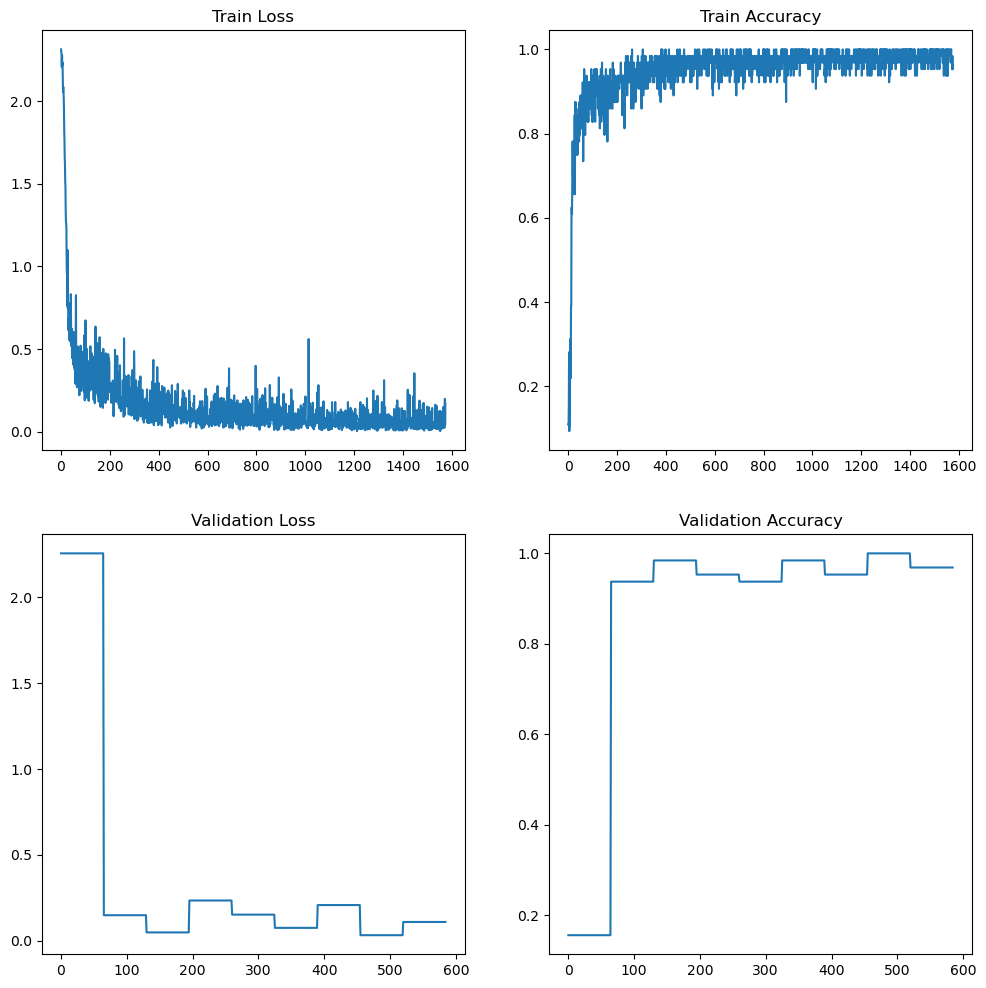

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax.flat[0].plot(LOGS["train_loss"])
ax.flat[0].set_title("Train Loss")

ax.flat[1].plot(LOGS["train_acc"])
ax.flat[1].set_title("Train Accuracy")

ax.flat[2].plot(LOGS["val_loss"])
ax.flat[2].set_title("Validation Loss")

ax.flat[3].plot(LOGS["val_acc"])
ax.flat[3].set_title("Validation Accuracy")

plt.show()

In [14]:
cpu_model = model.cpu()

# Prediction

### Form Setup

In [15]:
t1_output = widgets.Output()

image_id = widgets.BoundedIntText(
    value=7,
    min=0,
    max=len(val_dataset),
    step=1,
    description='Image id from dataset:',
    disabled=False,
    style={'description_width': 'initial'}
)
def t1_func(b):
    image_id_i = image_id.value
    with t1_output:
        clear_output()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(val_dataset[image_id_i][0].permute(1, 2, 0).numpy())
        plt.title("Selected image")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 2, 2)
        plt.axis('off')
        prediction = cpu_model(val_dataset[image_id_i][0].unsqueeze(0))
        info = f"""Number on image this is {torch.argmax(prediction).item()}"""

        plt.text(0, 1, info, fontsize=12, va='top')
        plt.tight_layout()
        plt.show()
        

t1_button = widgets.Button(description="Classify")
t1_button.on_click(t1_func)
form = widgets.VBox([image_id, t1_button, t1_output])

### Prediction form

In [16]:
display(form)